In [1]:
# Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Projects/Forecasting/Data/')

In [3]:
# Import Library

# Standart libraries
import glob
import math
import re
import warnings

# Data / Graph manipulation libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Preprocessing / Pipeline / Decomposition libraries
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import set_config

# Model Selection / Grid Search libraries
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.model_selection import GridSearchCV

# ML models 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

# Default settings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
sns.set_style(style='whitegrid')

# Function definitions


In [4]:
def WMAE(dataset, real, predicted):
    """
    Implementation of competition evaluation metric
    """
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [5]:
def print_correlation_matrix(df):
    """
    Default seaborn code to plot diagonal correlation matrix
    
    References:
    https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
    """
    corr = df.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.show()

In [6]:
def graph_relation_to_weekly_sale(col_relation, df, x='Week', palette=None):
    """
    This function plots the graph relation between 
    a categorized feature and the Weekly_Sales
    """
    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.relplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.show()

In [7]:
def create_groupped_analysis(col, df):
    """
    This function creates a  groupBy relation between the Weekly_Sales
    and the input column
    """
    unique_values = df[[col, 'Weekly_Sales']].groupby(by=col).mean().size
    print(f'The number of unique values on the category \'{col}\' is {unique_values}\n')
    print('-' * 40)
    print(f'The top 5 \'{col}\' with higher average \'Weekly_Sales\':')
    print('-' * 40)
    return (
        df[[col, 'Weekly_Sales']]
        .groupby(by=col)
        .mean()
        .sort_values('Weekly_Sales', ascending=False)
        .head()
    )

In [8]:
def plot_groupped_graph(col1, col2, df):
    """
    This function plots a relplot between one or two columns and
    the Weekly_Sales
    """
    if col2:
        df = (
            df[[col1, col2, 'Weekly_Sales']]
            .groupby([col1, col2])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )
    else:
        df = (
            df[[col1, 'Weekly_Sales']]
            .groupby([col1])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )

    df.reset_index(inplace=True)
    sns.relplot(
        x=col1,
        y='Weekly_Sales',
        hue=col2,
        data=df.sort_values(col1),
        height=5,
        aspect=2
    )

In [9]:
def plot_regression_results(y_true, y_pred, title, scores):
    """
    Scatter plot of the predicted vs true targets
    """
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

In [10]:
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance 
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [11]:
def model_factory(model_type, **kwargs):
    """
    This function creates a model considering the model_type
    and specific arguments.
    
    Reference: https://medium.com/xp-inc/desing-patterns-factory-method-a7496ae071aa
    """
    # Specific for RandomForestRegressor or ExtraTreesRegressor
    if model_type in ['RandomForestRegressor', 'ExtraTreesRegressor'] :
        n_estimators = kwargs.get('n_estimators')
        verbose = kwargs.get('verbose')
        n_jobs = kwargs.get('n_jobs')
        
        if n_estimators is None:   
            n_estimators = 50
        
        verbose = 0 if verbose is None else verbose

    if model_type == 'LinearRegression':
        return LinearRegression()
    elif model_type == 'KNN':
        return KNeighborsRegressor()
    elif model_type == 'Ridge':
        return RidgeCV()
    elif model_type == 'Lasso':
        return LassoCV()
    elif model_type == 'XGBRegressor':
        return XGBRegressor()
    elif model_type == 'RandomForestRegressor':
        return RandomForestRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    elif model_type == 'ExtraTreesRegressor':
        return ExtraTreesRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    else:
        raise ValueError('Model not defined on factory.')

# Preparing data and EDA

In [12]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [29]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [27]:
stores.shape

(45, 3)

In [14]:
df_train = features.merge(stores, how='left', on='Store')
df_train
df_train = train.merge(df_train, how='left', on=['Store', 'Date', 'IsHoliday'])
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [15]:
df_train.describe(include = 'all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570,421570.000000,421570,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570,421570.000000
unique,NaN,NaN,143,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,2011-12-23,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,3027,NaN,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215478,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,NaN,136727.915739
std,12.785297,30.492054,NaN,22711.183519,NaN,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,NaN,60980.583328
min,1.000000,1.000000,NaN,-4988.940000,NaN,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,NaN,34875.000000
25%,11.000000,18.000000,NaN,2079.650000,NaN,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,NaN,93638.000000
50%,22.000000,37.000000,NaN,7612.030000,NaN,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,NaN,140167.000000
75%,33.000000,74.000000,NaN,20205.852500,NaN,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,NaN,202505.000000


In [16]:
# Checking the NaN percentage
df_train.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

In [17]:
df_train.dropna(axis='columns', inplace=True)

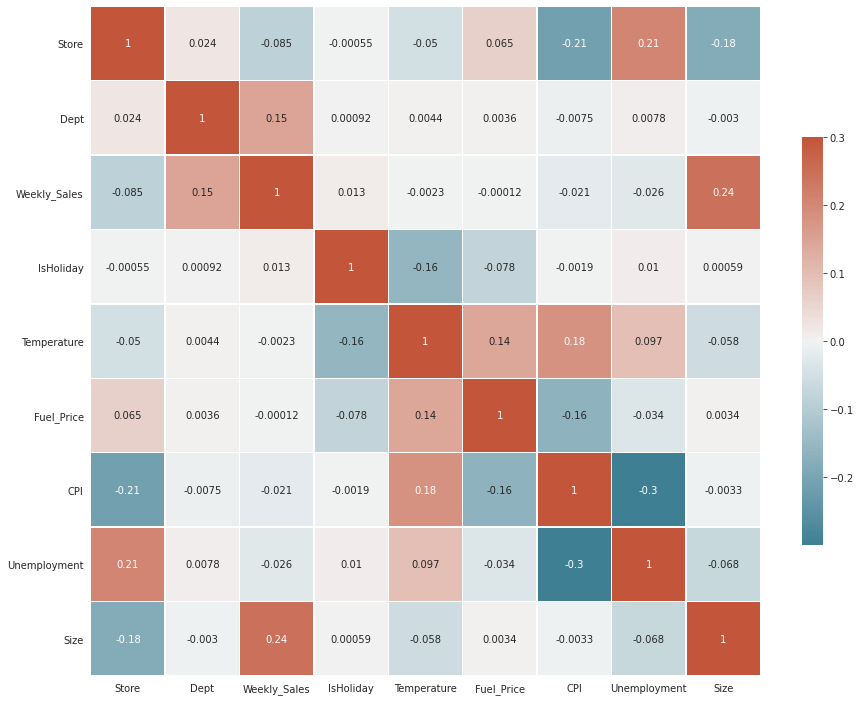

In [18]:
# Plotting the correlation matrix. Here I will check for relations with the Weekly Sales feature
print_correlation_matrix(df_train)

In [19]:
df_train.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI'], axis=1, inplace=True)

# Check for trend and seasonality

In [22]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,A,151315,5,2,2010
1,1,1,2010-02-12,46039.49,True,A,151315,6,2,2010
2,1,1,2010-02-19,41595.55,False,A,151315,7,2,2010
3,1,1,2010-02-26,19403.54,False,A,151315,8,2,2010
4,1,1,2010-03-05,21827.90,False,A,151315,9,3,2010


In [ ]:
def graph_relation_to_weekly_sale(col_relation, df, x='Week', palette=None):
    """
    This function plots the graph relation between 
    a categorized feature and the Weekly_Sales
    """
    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.relplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.show()

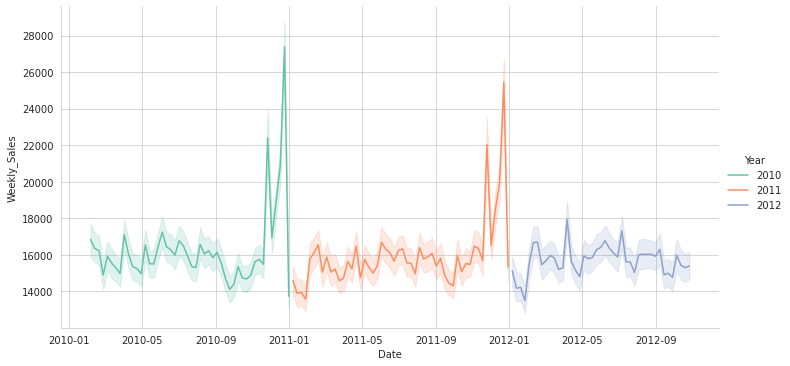

In [20]:
# Here we can see a sazonal behavior on the sales
graph_relation_to_weekly_sale('Year', df_train, x='Date', palette='Set2')

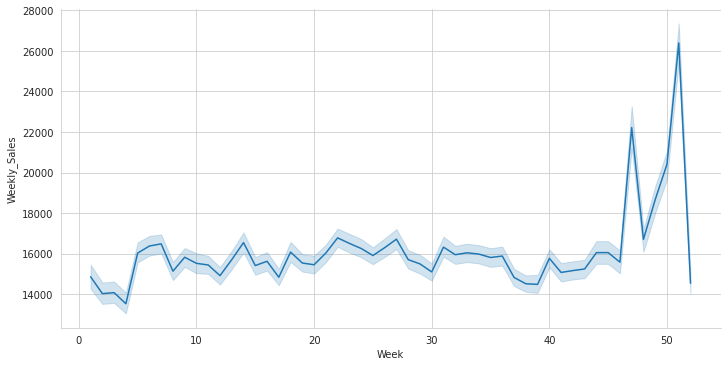

In [28]:
graph_relation_to_weekly_sale(None, df_train, x='Week')

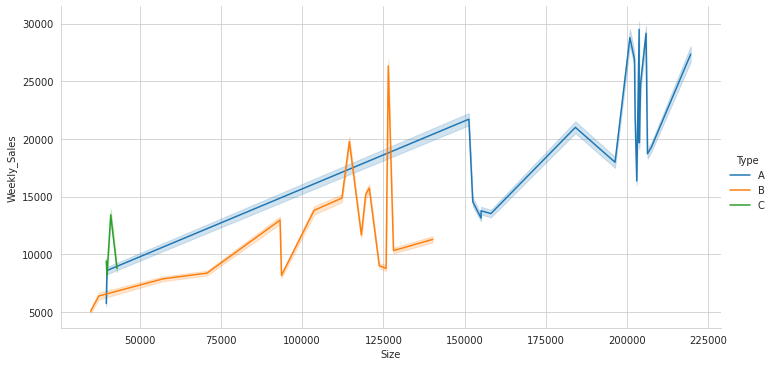

In [29]:
# We can check the correlation between the store and type on the graph below.
graph_relation_to_weekly_sale('Type', df_train, 'Size')

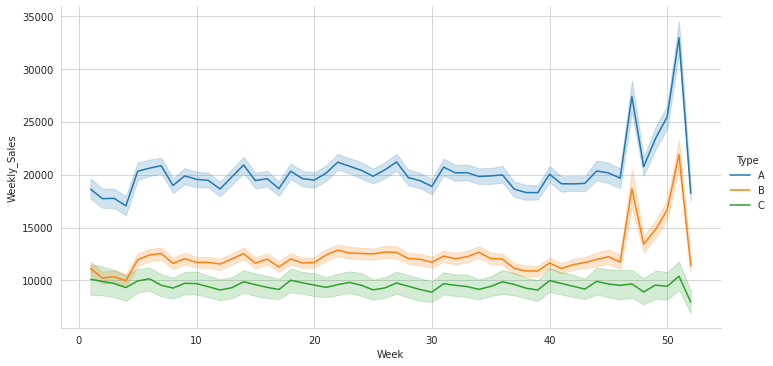

In [30]:
# We can also check this behavior for a year. Store type/store seems to be a multiplier
graph_relation_to_weekly_sale('Type', df_train)

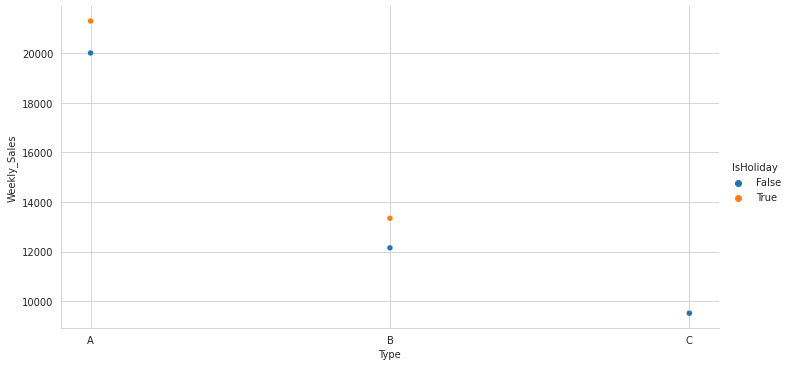

In [31]:
# On the graph below we can see the relation between 'IsHoliday' and 'Type'.
plot_groupped_graph('Type', 'IsHoliday', df_train)

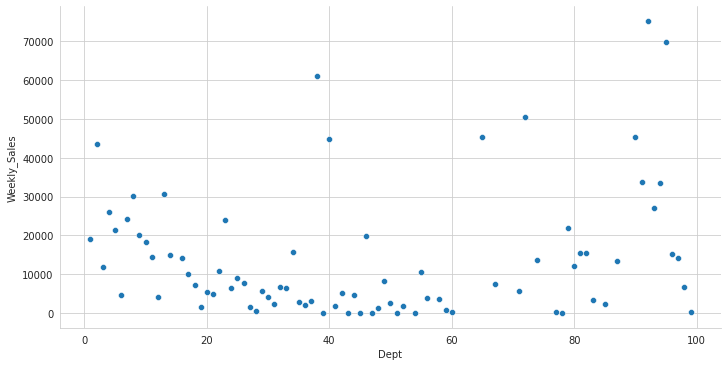

In [32]:
# On the graph below we can see the average weekly sales considering each `Dept`
plot_groupped_graph('Dept', None, df_train)

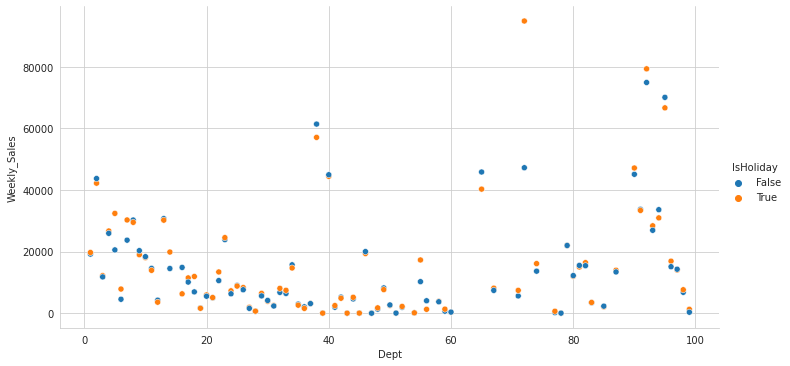

In [35]:
# On the graph below we can see the relation between 'IsHoliday' and 'Dept'
plot_groupped_graph('Dept', 'IsHoliday', df_train)

# Feature Engineering

I will create four features:

Week: week of the year

Month: month of the year

Year: observed year

HolidayType: [-1 = No Holiday, 0 = Super Bowl, 1 = Labor Day, 2 = Thanksgiving, 3 = Christmas]

In [36]:
def create_features(df):
    """
    This function creates the following features: Week, Month, Year and
    HolidayType
    """
    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1

    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]
    
    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])

    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Year'] =  df.Date.dt.year
    df['Month'] =  df.Date.dt.month
    
    # Convert all columns to float
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)


In [37]:
create_features(df_train)

In [39]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Week,Month,Year,HolidayType
0,1.0,1.0,2010-02-05,24924.50,False,A,151315.0,5.0,2.0,2010.0,-1.0
1,1.0,1.0,2010-02-12,46039.49,True,A,151315.0,6.0,2.0,2010.0,0.0
2,1.0,1.0,2010-02-19,41595.55,False,A,151315.0,7.0,2.0,2010.0,-1.0
3,1.0,1.0,2010-02-26,19403.54,False,A,151315.0,8.0,2.0,2010.0,-1.0
4,1.0,1.0,2010-03-05,21827.90,False,A,151315.0,9.0,3.0,2010.0,-1.0


In [40]:
# Divide dataset for training
X = df_train.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_train['Weekly_Sales']

In [45]:
categorical_features = X.columns[X.dtypes == 'O']
numeric_features = X.columns[X.dtypes == 'float64']

categories = [X[column].unique() for column in X[categorical_features]]
for cat in categories:
    cat[cat == None] = 'missing'

transform_categorical_features = make_pipeline(
    # Fill all NaN values to missing
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    # Transform categorical features into ordinal categories
    OrdinalEncoder(categories=categories)
)


transform_numeric_features = make_pipeline(
    # Fill all NaN values to -1
    SimpleImputer(strategy='constant', fill_value=-9999),
    # Standardize features by removing the mean and scaling to unit variance
    StandardScaler()
)

# Pre-processing transformation
preprocessing_step = make_column_transformer(
    (transform_categorical_features, categorical_features),
    (transform_numeric_features, numeric_features),
    remainder='passthrough'
)


In [41]:
# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
regression_models = [
    'LinearRegression',
    'KNN',
    'Ridge',
    'Lasso',
    'XGBRegressor',
    'RandomForestRegressor',
    'ExtraTreesRegressor'
]

best_model = None
best_error = math.inf

--------------------------------------------------
Training evaluation
--------------------------------------------------
:: LinearRegression - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


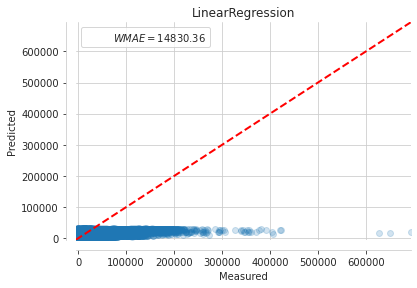

--------------------------------------------------
:: KNN - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.1min finished


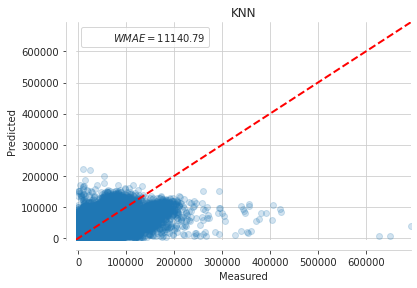

--------------------------------------------------
:: Ridge - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


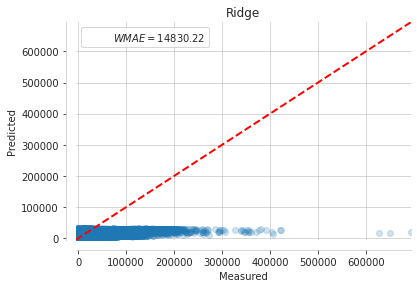

--------------------------------------------------
:: Lasso - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished


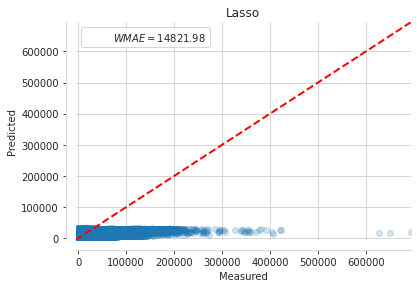

--------------------------------------------------
:: XGBRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.9s finished


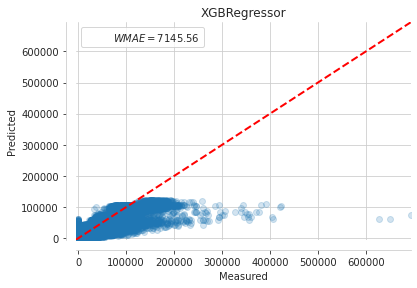

--------------------------------------------------
:: RandomForestRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


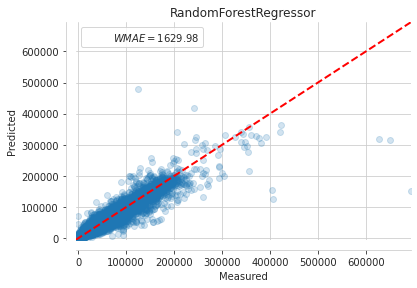

--------------------------------------------------
:: ExtraTreesRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


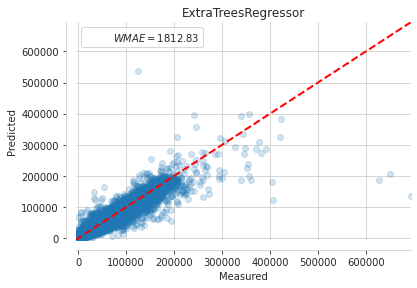

--------------------------------------------------


In [46]:
print('-' * 50)
print('Training evaluation')
print('-' * 50)

for name in regression_models:
    # Create a basic pipeline
    print(f':: {name} - Training Pipeline')
    regressor = model_factory(name)
    training_pipeline = make_pipeline(
        preprocessing_step,
        regressor
    )

    kfold = KFold(n_splits=3)

    y_pred = cross_val_predict(
        training_pipeline,
        X_train,
        y_train,
        cv = kfold,
        n_jobs = -1,
        verbose = 1
    )
    
    wmae_metric = WMAE(X_train, y_train, y_pred)
    
    if wmae_metric < best_error:
        best_error = wmae_metric
        best_model = name
    
    plot_regression_results(
        y_train,
        y_pred,
        name,
        (r'$WMAE ={:.2f}$').format(wmae_metric)
    )

    print('-' * 50)

In [47]:
print(f'Best model is {best_model}')
print(f'Best score is {best_error}')

Best model is RandomForestRegressor
Best score is 1629.98


# Finding best hyperpaprameter combination

In [48]:
# The number of trees in the forest
n_estimators = [x for x in range(50, 250, 50)]

# Create the random grid
random_grid = {
    'model__n_estimators': n_estimators
}

random_grid

{'model__n_estimators': [50, 100, 150, 200]}

In [49]:
def get_best_model_parameters(random_grid, X, y):
    if best_model in ['ExtraTreesRegressor', 'RandomForestRegressor']:
        model = model_factory(best_model)
    else:
        # grid search not implemented for other models
        return {'model__n_estimators': None}

    grid_pipeline =  Pipeline(
        [("preprocessing", preprocessing_step),
         ("model", model)]
    )

    kfold = KFold(n_splits=3)

    model_random = GridSearchCV(
        grid_pipeline,
        param_grid = random_grid,
        cv = kfold,
        verbose = 2,
        n_jobs = -1
    )

    # Create a sample to speed up parameter search
    X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9)
    return model_random.fit(X_sample, y_sample).best_params_

    # Best Parameter combination
best_params = get_best_model_parameters(random_grid, X, y)
best_params

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.9min finished


{'model__n_estimators': 200}

# Training the full dataset

In [51]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 6.8MB 5.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [53]:
print('-' * 70)
print(f'Best Model: {best_model}: {best_params}\n')
print('Tip: click on the Pipeline diagram below to have a better view of each step.')
print('-' * 70)

model = model_factory(
    best_model,
    n_estimators = best_params['model__n_estimators'],
    verbose = 1,
    n_jobs = -1
)

best_model_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_step),
        ("model", model)
    ]
)

# set_config(display='diagram')
best_model_pipeline.fit(X_train, y_train)

----------------------------------------------------------------------
Best Model: RandomForestRegressor: {'model__n_estimators': 200}

Tip: click on the Pipeline diagram below to have a better view of each step.
----------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=None,
                                                                                 strategy='constant',
                                

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    7.0s finished


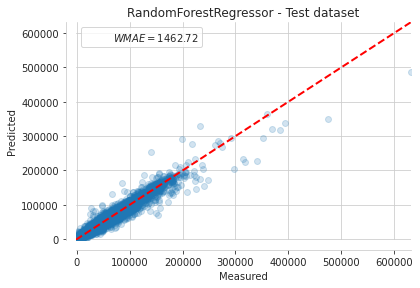

In [54]:
y_pred = best_model_pipeline.predict(X_test)
wmae_metric = WMAE(X_test, y_test, y_pred)

plot_regression_results(
    y_test,
    y_pred,
    f'{best_model} - Test dataset',
    (r'$WMAE ={:.2f}$').format(wmae_metric)
)

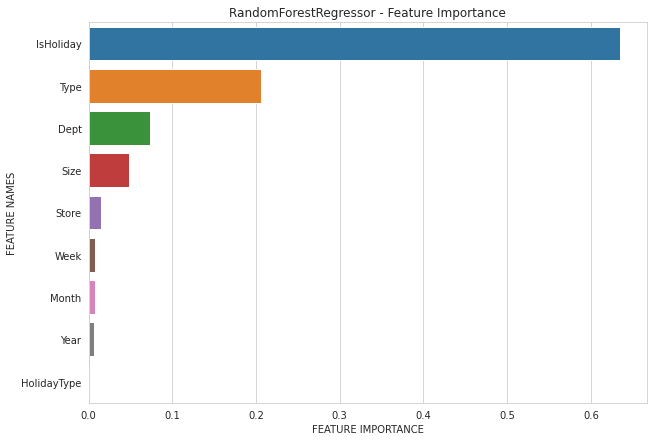

In [55]:
features_importance = best_model_pipeline.steps[1][1].feature_importances_
    
plot_features_importance(
    features_importance,
    X_test.columns,
    best_model
)

# Testing the model on Test set

In [57]:
# Creates df_test dataset
df_test = features.merge(stores, how='left', on='Store')
df_test = test.merge(df_test, how='left', on=['Store', 'Date', 'IsHoliday'])
create_features(df_test)
df_test = df_test[list(X_train.columns)]
df_test.head()

,Store,Dept,IsHoliday,Type,Size,Week,Month,Year,HolidayType
0,1.0,1.0,False,A,151315.0,44.0,11.0,2012.0,-1.0
1,1.0,1.0,False,A,151315.0,45.0,11.0,2012.0,-1.0
2,1.0,1.0,False,A,151315.0,46.0,11.0,2012.0,-1.0
3,1.0,1.0,True,A,151315.0,47.0,11.0,2012.0,2.0
4,1.0,1.0,False,A,151315.0,48.0,11.0,2012.0,-1.0


In [58]:
y_pred = best_model_pipeline.predict(df_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    3.1s finished


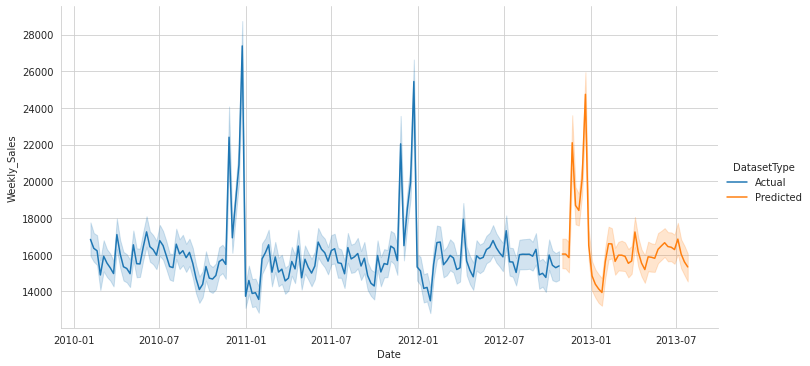

In [61]:
df_test['Weekly_Sales'] = y_pred
df_test['DatasetType'] = 'Predicted'
df_test['Date'] = test['Date'].values # we dropped this column earlier

df_train['DatasetType'] = 'Actual'
df_train['Date'] = train['Date'].values # we dropped this column earlier

df_result = df_train.append(df_test)

graph_relation_to_weekly_sale('DatasetType', df_result, x='Date')